# Install and import libraries

In [1]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    tavily-python\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (set

In [2]:
!pip install --upgrade --quiet  rank_bm25 > /dev/null
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 9.4 MB/s eta 0:00:00


In [12]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.embeddings import CacheBackedEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import EnsembleRetriever
from langchain_core.documents.base import Document
from langchain.storage import LocalFileStore
from langchain.cache import InMemoryCache
from langchain_together import ChatTogether
from langchain.prompts import ChatPromptTemplate
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage
import requests
from bs4 import BeautifulSoup

In [4]:
os.environ["TAVILY_API_KEY"] = "YOUR_TAVILY_API_KEY"
os.environ["TOGETHER_API_KEY"] = "YOUR_TOGETHER_API_KEY"

# Section 1

In [5]:
import requests
from bs4 import BeautifulSoup

# send a GET request to the website
url = 'https://stanford.edu/~jurafsky/slp3/'
response = requests.get(url)

# parse the HTML content of the page with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# find all links on the page
links = soup.find_all('a')

pdflinks = []

# print the href attribute of each link
for link in links:
    ref = link.get('href')
    if ref.endswith('.pdf'):
      pdflinks.append(url+ref)

In [7]:
pdflinks.pop(0)
pdflinks

['https://stanford.edu/~jurafsky/slp3/2.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/2_TextProc_2023.pdf',
 'https://stanford.edu/~jurafsky/slp3/3.pdf',
 'https://stanford.edu/~jurafsky/slp3/4.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/4_NB_2024.pdf',
 'https://stanford.edu/~jurafsky/slp3/5.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/5_LR_Apr_7_2021.pdf',
 'https://stanford.edu/~jurafsky/slp3/6.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/vectorsemantics2024.pdf',
 'https://stanford.edu/~jurafsky/slp3/7.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/7_NN_Apr_28_2021.pdf',
 'https://stanford.edu/~jurafsky/slp3/8.pdf',
 'https://stanford.edu/~jurafsky/slp3/slides/8_POSNER_intro_May_6_2021.pdf',
 'https://stanford.edu/~jurafsky/slp3/9.pdf',
 'https://stanford.edu/~jurafsky/slp3/10.pdf',
 'https://stanford.edu/~jurafsky/slp3/11.pdf',
 'https://stanford.edu/~jurafsky/slp3/13.pdf',
 'https://stanford.edu/~jurafsky/slp3/14.pdf',
 'https://stanford.edu/~jurafsky/

In [8]:
documents = []
for pdf_path in pdflinks:
  loader = PyPDFLoader(pdf_path)
  documents.extend(loader.load())

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
chunked_documents = text_splitter.split_documents(documents)

In [10]:
len(chunked_documents)

3700

# Section 2

In [13]:
store = LocalFileStore("./cache/")
embeddings_model = HuggingFaceEmbeddings(show_progress=True, multi_process=True)
embedder = CacheBackedEmbeddings.from_bytes_store(embeddings_model,
                                                  store,
                                                  namespace=embeddings_model.model_name)
# Create VectorStore
vectorstore = FAISS.from_documents(documents=chunked_documents,embedding=embedder)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
list(store.yield_keys())[:5]

['sentence-transformers/all-mpnet-base-v2b43e216c-e1d2-5044-8b8b-1c21041d2e44',
 'sentence-transformers/all-mpnet-base-v21273176c-720e-590a-b026-912d8059e292',
 'sentence-transformers/all-mpnet-base-v2692cc87a-d00d-5309-9228-57d1c8bd4c15',
 'sentence-transformers/all-mpnet-base-v2da33bb4f-f6f6-5f5f-8688-9ee92f3e588b',
 'sentence-transformers/all-mpnet-base-v2c166751a-6fca-5e4e-bf5c-e312a58397fb']

# Section 3

In [22]:
documents_text = []
for doc in documents:
  documents_text.append(doc.page_content)

In [23]:
bm25_retriever = BM25Retriever.from_texts(
    documents_text, metadatas=[{"source": 1}] * len(documents_text)
)
bm25_retriever.k = 2

faiss_retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
retriever_chain = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
)

In [30]:
# Example weights tuning
for weight_faiss in [0, 1]:
    weight_bm25 = 1 - weight_faiss
    retriever_chain.weights = [weight_bm25, weight_faiss]

    # Test the retriever with a sample query
    print(f"Weight for FAISS: {weight_faiss}")
    print(f"Weight for BM25: {weight_bm25}\n")
    print("Testing retriever with a sample query:")
    query = "ٌWhat are the applications of BERT?"
    retrieved_docs = retriever_chain.get_relevant_documents(query)
    print(f"Retrieved docs: {retrieved_docs}")


    query = "ٌWhat is self-attention?"
    retrieved_docs = retriever_chain.get_relevant_documents(query)
    print(f"Retrieved docs: {retrieved_docs}")

    query = "ٌWho is the president of USA?"
    retrieved_docs = retriever_chain.get_relevant_documents(query)
    print(f"Retrieved docs: {retrieved_docs}")

    print("-----------------------------")

Weight for FAISS: 0
Weight for BM25: 1

Testing retriever with a sample query:
Retrieved docs: [Document(metadata={'source': 1}, page_content='11.4 • F INE-TUNING LANGUAGE MODELS 13\nmodels or from autoregressive ones) have the property that the vectors for all words\nare extremely similar. If we look at the embeddings from the ﬁnal layer of BERT\nor other models, embeddings for instances of any two randomly chosen words will\nhave extremely high cosines that can be quite close to 1, meaning all word vectors\ntend to point in the same direction. The property of vectors in a system all tending\nto point in the same direction is known as anisotropy . Ethayarajh (2019) deﬁnes\ntheanisotropy of a model as the expected cosine similarity of any pair of words in anisotropy\na corpus. The word ‘isotropy’ means uniformity in all directions, so in an isotropic\nmodel, the collection of vectors should point in all directions and the expected cosine\nbetween a pair of random embeddings would be ze

In [34]:
weight_bm25 = 0.3
weight_faiss = 0.7
retriever_chain.weights = [weight_bm25, weight_faiss]

In [35]:
query = "ٌWhat is self-attention?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

query = "ٌWhat is binary search tree?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

query = "ٌWho is the president of Bolivia?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

print("-----------------------------")

Retrieved docs: [Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/10.pdf', 'page': 4}, page_content='10.1 • T HETRANSFORMER : A S ELF-ATTENTION NETWORK 5\nSelf-AttentionLayerx1a1\nx2a2a3a4a5\nx3x4x5\nFigure 10.2 Information ﬂow in a causal (or masked) self-attention model. In processing\neach element of the sequence, the model attends to all the inputs up to, and including, the\ncurrent one. Unlike RNNs, the computations at each time step are independent of all the\nother steps and therefore can be performed in parallel.\n10.1.3 Self-attention more formally\nWe’ve given the intuition of self-attention (as a way to compute representations of a\nword at a given layer by integrating information from words at the previous layer)\nand we’ve deﬁned context as all the prior words in the input. Let’s now introduce\nthe self-attention computation itself.\nThe core intuition of attention is the idea of comparing an item of interest to a\ncollection of other items in a way that r

In [36]:
weight_bm25 = 0.2
weight_faiss = 0.8
retriever_chain.weights = [weight_bm25, weight_faiss]

In [37]:
query = "ٌWhat is self-attention?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

query = "ٌWhat is binary search tree?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

query = "ٌWho is the president of Bolivia?"
retrieved_docs = retriever_chain.get_relevant_documents(query)
print(f"Retrieved docs: {retrieved_docs}")

print("-----------------------------")

Retrieved docs: [Document(metadata={'source': 'https://stanford.edu/~jurafsky/slp3/10.pdf', 'page': 4}, page_content='10.1 • T HETRANSFORMER : A S ELF-ATTENTION NETWORK 5\nSelf-AttentionLayerx1a1\nx2a2a3a4a5\nx3x4x5\nFigure 10.2 Information ﬂow in a causal (or masked) self-attention model. In processing\neach element of the sequence, the model attends to all the inputs up to, and including, the\ncurrent one. Unlike RNNs, the computations at each time step are independent of all the\nother steps and therefore can be performed in parallel.\n10.1.3 Self-attention more formally\nWe’ve given the intuition of self-attention (as a way to compute representations of a\nword at a given layer by integrating information from words at the previous layer)\nand we’ve deﬁned context as all the prior words in the input. Let’s now introduce\nthe self-attention computation itself.\nThe core intuition of attention is the idea of comparing an item of interest to a\ncollection of other items in a way that r

# Section 4

In [38]:
llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0
    )

In [68]:
router_prompt_template = (
 """You are an intelligent assistant with the ability to classify user queries. Your task is to determine whether a given query is related to Natural Language Processing (NLP), Computer Science (CS), or neither of them. Use the following guidelines to make your classification:
Natural Language Processing (NLP): Queries related to understanding, generating, or processing human language using computational methods. This includes topics like sentiment analysis, language translation, text generation, speech recognition, and other linguistics-based computational tasks.
Computer Science (CS): Queries related to general computer science topics excluding NLP. This includes areas such as algorithms, data structures, programming languages, software engineering, databases, networking, artificial intelligence (excluding NLP-specific topics), computer architecture, and cybersecurity.
If the query is related to NLP, just return the string VectorStore.
If the query is related to CS, just return the string SearchEngine
If the query is related to neither NLP nor CS, just return the string None.
{output_instructions}
query: {query}"""
)


prompt = ChatPromptTemplate.from_template(
    template=router_prompt_template,
)

In [69]:
class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"] = Field(description="the tool that was chosen by LLM in question routing stage")

router_chain_parser = PydanticOutputParser(pydantic_object=ChosenTool)
router_chain = prompt | llm | router_chain_parser

# Section 5

In [41]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=5)
await search.ainvoke("what is AI?")

[{'url': 'https://www.mediapost.com/publications/article/392343/ces-has-plenty-of-smart-asses-this-year-it-will-s.html',
  'content': 'Incubated by a team of AI experts at Stagwell\'s U.K.-based Locaria agency, which they developed the generative AI platform capable of automatically analyzing, categorizing and managing creative advertising assets based on how well they perform -- or don\'t. advertisement advertisement "AI is a quantum leap for creativity\xa0and\xa0productivity that will drive a new age of value creation for modern business. Username Password Forgot? Become a free MediaPost member now to read this article Log in if you are already a member Username Password Forgot?  Username Password Remember me Forgot your password? Subscribe today to gain access to every Research Intelligencer article we publish as well as the exclusive daily newsletter, full access to The MediaPost Cases, first-look research and daily insights from Joe Mandese, Editor in Chief.  "Whether you\'re a gl

In [42]:
class ParsedDocument(BaseModel):
    content: str = Field(description="This refers to the content of the search.")
    url: str = Field(description="This refers to the url of the search.")

# Define a custom parser
def custom_parser(search_results):
    parsed_documents = []
    for result in search_results:  # Adjust this line based on the actual structure of search_results
        parsed_document = ParsedDocument(content=result['content'], url=result['url'])
        document = Document(page_content=parsed_document.content, metadata={'url': parsed_document.url})
        parsed_documents.append(document)
    return parsed_documents

search_engine_chain = search | custom_parser

In [117]:
out = await search_engine_chain.ainvoke("what is AI?")

In [118]:
out

[Document(metadata={'url': 'https://www.ibm.com/topics/artificial-intelligence'}, page_content='But since the advent of electronic computing (and relative to some of the topics discussed in this article) important events and milestones in the evolution of artificial intelligence include the following:\nPut AI to work in your business with IBM’s industry-leading AI expertise and portfolio of solutions at your side.\n In it, they delve into four potential goals or definitions of AI, which differentiates computer systems on the basis of rationality and thinking vs. acting:\nHuman approach:\nIdeal approach:\nAlan Turing’s definition would have fallen under the category of “systems that act like humans.”\n IBM acquires Manta to complement data and AI governance capabilities\nIBM watsonx Orchestrate\nIBM watsonx Assistant\nExplore Gen AI learning for developers\nWeak AI—also called Narrow AI or Artificial Narrow Intelligence (ANI)—is AI trained and focused to perform specific tasks. While a 

# Section 6

In [71]:
prompt_template = (
  """You are expert in checking relevancy. Given a query and a document and you have the task to check whether or not the document is relevant to the query.
If the document and queury was related to each other just return relevant otherwise just return irrelevant.
{output_instructions}
document: {document}
query: {query}"""
)


prompt = ChatPromptTemplate.from_template(
    template=prompt_template,
)

In [72]:
class CheckQuery(BaseModel):
    relevancy: Literal["relevant", "irrelevant"] = Field(description="This specifies whether the user's query is relevant or irrelevant")

relevancy_check_parser = PydanticOutputParser(pydantic_object=CheckQuery)
relevancy_check_chain = prompt | llm | relevancy_check_parser

In [82]:
relevancy_check_chain.invoke(
    {
        "output_instructions": relevancy_check_parser.get_format_instructions(),
        "query": "What is chatbot?",
        "document": chunked_documents[:5],
    }
)

CheckQuery(relevancy='relevant')

# Section 7

In [46]:
fallback_prompt = ChatPromptTemplate.from_template(
    ("""You are a responsive chatbot in the field of Computer Science (CS) with special expertise in Natural Language Processing (NLP). You are very helpfully.
You only answer questions that are related to NLP or CS. Generate the answer considering your limitations.
If the question is not related to NLP or CS, apologize and explain that these questions are not in your field of expertise.
Finally, politely ask him to ask questions only about NLP or CS.

Current conversations:\n\n{chat_history}\n\n
human: {query}"""
    )
)

llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0.1
    )

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to help with any questions you have in the field of Computer Science, particularly in Natural Language Processing (NLP). What would you like to know or discuss? Do you have a specific question or topic in mind?"

# Section 8

In [48]:
generate_with_context_template = (
    """You are a helpful chatbot. You are given a query and a context and you must generate the answer using the given context. Just generate answer based on the given context and not more. If your context was not enough just explain your knowledge is limit and can not answer the query.
context: {context}\n\n
query: {query}"""
)


generate_with_context_prompt = ChatPromptTemplate.from_template(generate_with_context_template)
generate_with_context_chain = generate_with_context_prompt | llm | StrOutputParser()

# Section 9

In [135]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
import operator
import asyncio




class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]

def router_node(state: dict):
    query = state["query"]
    try:
        response = router_chain.invoke({"query": query,
                                   "output_instructions": router_chain_parser.get_format_instructions()
        })
        print(response)
    except Exception:
        print("Exception in getting response")
        return "LLMFallback"
    try:
      chosen_tool = response.tool_name.lower()
    except Exception:
        return "LLMFallback"

    if chosen_tool == 'searchengine':
      print("---Routing to SearchEngine---")
      return "SearchEngine"

    if chosen_tool == "vectorstore":
        print("---Routing to VectorStore---")
        return "VectorStore"

    if chosen_tool == 'none':
        print("---No tool called---")
        return "LLMFallback"


def vector_store(state: dict):
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever_chain.invoke(input=query)
    return {"documents": documents}

def search_engine(state: dict):
    query = state["query"]
    async def asyncfunc(query):
        return await search_engine_chain.ainvoke(query)
    documents = asyncio.run(asyncfunc(query))

    return {"documents": documents}

def filter_docs(state: dict):
    query = state["query"]
    documents = state["documents"]
    relevant_docs = []

    for doc in documents:
      try:
        response = relevancy_check_chain.invoke({"document": doc,
                                        "query": query,
                                        "output_instructions": relevancy_check_parser.get_format_instructions()
            })
        print(response)

        relevancy = response.relevancy.lower()

        if relevancy == "relevant":
            relevant_docs.append(doc)
      except Exception:
        print("Exception in getting response")
        continue

    state["documents"] = relevant_docs

def fallback(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}

def generate_with_context(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = generate_with_context_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}

def check_documents(state: dict):
    documents = state["documents"]

    if len(documents) != 0:
      return "Generate"

    return "SearchEngine"


In [136]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)

workflow.add_node("vector_store", vector_store)
workflow.add_node("fallback", fallback)
workflow.add_node("filter_docs", filter_docs)
workflow.add_node("search_engine", search_engine)
workflow.add_node("generate_with_context", generate_with_context)

workflow.set_conditional_entry_point(
    router_node,
    {
        "SearchEngine": "search_engine",
        "VectorStore": "vector_store",
        "LLMFallback": "fallback",
    },
)



workflow.add_conditional_edges(
    "filter_docs",
    check_documents,
    {
        "Generate": "generate_with_context",
        "SearchEngine": "search_engine"
    }
)

workflow.add_edge("vector_store", "filter_docs")
workflow.add_edge("search_engine", "filter_docs")


workflow.add_edge("generate_with_context", END)

workflow.add_edge("fallback", END)

In [137]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

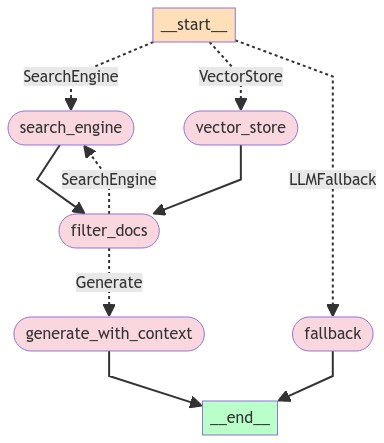

In [138]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img = Image.open(BytesIO(plot))
display(img)

In [139]:
response = app.invoke({"query": "what are the binary search trees?", "chat_history": []})
Markdown(response["generation"])

tool_name='SearchEngine'
---Routing to SearchEngine---
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'


A Binary Search Tree is a data structure used in computer science for organizing and storing data in a sorted manner. Each node in a Binary Search Tree has at most two children, a left child and a right child, with the left child containing values less than the parent node and the right child containing values greater than the parent node.

In [141]:
response = app.invoke({"query": "Hi I'm Zahra!", "chat_history": []})
Markdown(response["generation"])

tool_name='None'
---No tool called---


Hi Zahra! Nice to meet you! I'm a chatbot with expertise in Computer Science, particularly in Natural Language Processing (NLP). I'm here to help answer any questions you may have in these areas. What would you like to know or discuss?

In [78]:
response = app.invoke({"query": "what are transformers?", "chat_history": []})
Markdown(response["generation"])

tool_name='VectorStore'
---Routing to VectorStore---
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'
relevancy='irrelevant'
relevancy='irrelevant'
relevancy='irrelevant'


According to the context, transformers are a neural architecture that can handle distant information. They are made up of stacks of transformer blocks, each of which is a multilayer network that maps sequences of input vectors to sequences of output vectors of the same length. These blocks are made by combining simple linear layers, feedforward networks, and self-attention layers, the key self-attention innovation of transformers. Self-attention allows a network to directly extract and use information from arbitrarily large contexts.

In [143]:
response = app.invoke({"query": "what is chatbot?", "chat_history": []})
Markdown(response["generation"])

tool_name='VectorStore'
---Routing to VectorStore---
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'
relevancy='irrelevant'
relevancy='irrelevant'
relevancy='irrelevant'


According to the context, a chatbot is a conversational system designed to mimic the appearance of informal human conversation. It is a type of conversational agent that can carry on longer and more unstructured conversations, similar to human-human interaction.

In [144]:
response = app.invoke({"query": "why sky is blue?", "chat_history": []})
Markdown(response["generation"])

tool_name='None'
---No tool called---


I'm happy to help! However, I must apologize that the question "why sky is blue?" is not within my field of expertise, which is specifically focused on Computer Science (CS) and Natural Language Processing (NLP).

As a chatbot, I'm designed to provide assistance and answer questions related to CS and NLP, but I'm not equipped to provide explanations on topics outside of these domains, such as physics or atmospheric science.

If you have any questions related to NLP or CS, I'd be more than happy to help! For example, you could ask me about topics like language models, machine learning, algorithms, or programming languages. Please feel free to ask, and I'll do my best to provide a helpful response.

In [145]:
response = app.invoke({"query": "Tell me some programming languages.", "chat_history": []})
Markdown(response["generation"])

tool_name='SearchEngine'
---Routing to SearchEngine---
relevancy='relevant'
relevancy='relevant'
relevancy='relevant'
relevancy='irrelevant'
relevancy='irrelevant'


Based on the provided context, some programming languages mentioned are:

1. Python
2. JavaScript
3. C++
4. Rust
5. HTML/CSS